# Modelagem para o problema X-Health

## Importando Bibliotecas

In [1]:
#adicionando retorno no diretório ao caminho
import sys
sys.path.append('../')

#ignorar warnings 
import warnings
warnings.filterwarnings('ignore')

#informação de diretórios
from x_health.config import *

# arquivo auxiliar
from x_health.xgboost_utils import *

2025-02-06 00:14:37.512 | INFO     | x_health.config:<module>:11 - PROJ_ROOT path is: C:\Users\Natalia\OneDrive\Documentos\PROJETOS\Kognita\x_health


In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

import xgboost as xgb
import optuna

#from sklearn.preprocessing import LabelEncoder
import pickle

## Adicionando base e definindo var_alvo

In [3]:
#importando a base do arquivo externo
nome_base = f'{EXTERNAL_DATA_DIR}/dataset_2021-5-26-10-14.csv'
#nome_base = f'{PROCESSED_DATA_DIR}/01-x-health-consolid_cols.csv'
df = pd.read_csv(nome_base, sep = '\t', encoding='utf-8', na_values="missing")
backup = df.copy()
logger.info(f'Base importada com tamanho: {len(df)}')

2025-02-06 00:14:40.171 | INFO     | __main__:<module>:6 - Base importada com tamanho: 117273


In [4]:
#Definir a variavel alvo
var_alvo = 'default'  # Variável alvo

In [5]:
df.columns.values

array(['default_3months', 'ioi_36months', 'ioi_3months',
       'valor_por_vencer', 'valor_vencido', 'valor_quitado',
       'quant_protestos', 'valor_protestos', 'quant_acao_judicial',
       'acao_judicial_valor', 'participacao_falencia_valor',
       'dividas_vencidas_valor', 'dividas_vencidas_qtd',
       'falencia_concordata_qtd', 'tipo_sociedade', 'opcao_tributaria',
       'atividade_principal', 'forma_pagamento', 'valor_total_pedido',
       'month', 'year', 'default'], dtype=object)

In [6]:
df.isna().sum().sort_values(ascending=False)

forma_pagamento                32477
opcao_tributaria               18325
tipo_sociedade                   608
atividade_principal              592
default_3months                    0
ioi_36months                       0
valor_quitado                      0
valor_vencido                      0
valor_por_vencer                   0
ioi_3months                        0
quant_protestos                    0
valor_protestos                    0
quant_acao_judicial                0
acao_judicial_valor                0
falencia_concordata_qtd            0
dividas_vencidas_qtd               0
dividas_vencidas_valor             0
participacao_falencia_valor        0
valor_total_pedido                 0
month                              0
year                               0
default                            0
dtype: int64

## Transformações e normalizações

In [7]:
df.isna().sum().sort_values(ascending=False)

forma_pagamento                32477
opcao_tributaria               18325
tipo_sociedade                   608
atividade_principal              592
default_3months                    0
ioi_36months                       0
valor_quitado                      0
valor_vencido                      0
valor_por_vencer                   0
ioi_3months                        0
quant_protestos                    0
valor_protestos                    0
quant_acao_judicial                0
acao_judicial_valor                0
falencia_concordata_qtd            0
dividas_vencidas_qtd               0
dividas_vencidas_valor             0
participacao_falencia_valor        0
valor_total_pedido                 0
month                              0
year                               0
default                            0
dtype: int64

In [8]:
### criar flag
df["flag_valor_vencido"] = (df["valor_vencido"] > 0).astype(int)

In [9]:
## criar agrupamento da forma de pagamento
df['forma_pagamento_agrup'] = agrupar_prazo(df, 'forma_pagamento')

In [10]:
#Cria separação por trimestres
df["periodo_fiscal"] = df["month"].apply(lambda x: "1T" if x in [1, 2, 3] else 
                                         "2T" if x in [4, 5, 6] else 
                                         "3T" if x in [7, 8, 9] else "4T")

In [11]:
# Criar razão entre valor vencido e valor total pago(+1 para evitar divisão por 0)
df["razao_valor_vencido"] = df["valor_vencido"] / (df["valor_quitado"] + 1)

In [12]:
# Criar histórico de pagamento como proporção de valores pagos em relação ao vencido
df["historico_pagamento"] = df["valor_quitado"] / (df["valor_quitado"] + df["valor_vencido"] + 1)

In [13]:
df = tratar_categoricas(df)

#### Seleção de features

In [14]:
colunas = [ # lista de colunas a serem utilizadas    
    'flag_valor_vencido',
    'quant_protestos',
    'default_3months',
    'opcao_tributaria',
    'razao_valor_vencido',
    'forma_pagamento_agrup',

    #'valor_vencido', #ja foi usada a flag
    'periodo_fiscal',
    'ioi_3months',
    'historico_pagamento',
]

### Preparo de teste e treino

In [15]:
## preparar variaveis e separar em teste e treino
X_train, X_test, y_train, y_test = preparar_dados(df[colunas + [var_alvo]], target=var_alvo)

In [16]:
X_train.columns, X_test.columns

(Index(['flag_valor_vencido', 'quant_protestos', 'default_3months',
        'opcao_tributaria', 'razao_valor_vencido', 'forma_pagamento_agrup',
        'periodo_fiscal', 'ioi_3months', 'historico_pagamento'],
       dtype='object'),
 Index(['flag_valor_vencido', 'quant_protestos', 'default_3months',
        'opcao_tributaria', 'razao_valor_vencido', 'forma_pagamento_agrup',
        'periodo_fiscal', 'ioi_3months', 'historico_pagamento'],
       dtype='object'))

In [17]:
# Criando os DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
# Calcular scale_pos_weight
contagem_classes = np.bincount(y_train)  # Conta os valores 0 e 1 no y_train

scale_pos_weight = contagem_classes[0] / contagem_classes[1]
print(f"scale_pos_weight sugerido: {scale_pos_weight:.2f}")

scale_pos_weight sugerido: 5.00


In [19]:
# Configuração do modelo
params = {
    'objective': 'binary:logistic',  # Classificação binária
    'eval_metric': 'auc',        
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

## Modelo pre-optuna

In [20]:
# Treinando o modelo
model = xgb.train(params, dtrain, num_boost_round=100)

In [21]:
# Previsões de probabilidades
y_pred_train_prob = model.predict(dtrain)
y_pred_test_prob = model.predict(dtest)

# Convertendo as probabilidades para classificação binária (0 ou 1)
y_pred_train = (y_pred_train_prob > 0.5).astype(int)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

# Valores reais (y_true)
y_true_train = y_train.values
y_true_test = y_test.values

#### Métricas e Matriz de Confusão

In [22]:
# Chamando a função de avaliação:
metrica_inicial = avaliar_XGBoost(model, dtrain, y_train, dtest, y_test)
result = metrica_inicial['Teste']/metrica_inicial['Treino']
metrica_inicial, result

(    Métrica    Treino     Teste
 0   AUC-ROC  0.845713  0.824839
 1  Acurácia  0.775086  0.760350
 2  Precisão  0.403782  0.381964
 3    Recall  0.733372  0.708621
 4  F1-score  0.520813  0.496371
 5  Log Loss  0.487714  0.504006,
 0    0.975318
 1    0.980988
 2    0.945965
 3    0.966251
 4    0.953070
 5    1.033406
 dtype: float64)

Figura salva em: C:\Users\Natalia\OneDrive\Documentos\PROJETOS\Kognita\x_health\reports\figures/matriz_confusao_XGBoost_inicial.png


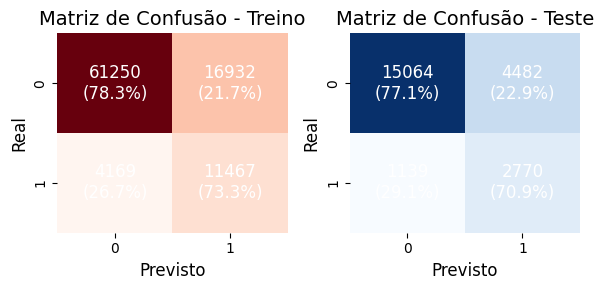

In [23]:
plot_matriz_confusao(y_true_train, y_pred_train, y_true_test, y_pred_test, 
                     size=(6,3), cmap_train="Reds", cmap_test="Blues", 
                     save_path=f'{FIGURES_DIR}/matriz_confusao_XGBoost_inicial.png')

### Optuna

In [24]:
# desabilita warnings do optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Configurar o nível de log no Optuna
logger.disable("optuna")  # Desativa logs do Optuna no loguru

In [25]:
#metrica da função
metrica = "test-auc-mean"

# Função de otimização do Optuna
def objective(trial):
    
    params = {
        "objective": "binary:logistic",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", max(1.0, scale_pos_weight - 0.8), scale_pos_weight - 0.4), ########## 2- ESTAVA 1-3
        "eval_metric": "auc",  # Avalia a métrica AUC
        "max_depth": trial.suggest_int("max_depth", 3, 6), ############ 3- ESTAVA 3-10
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), ########### 4- estava 0.01 - 0.3
        "n_estimators": trial.suggest_int("n_estimators", 50, 200), ########## 1- ESTAVA 500
        "subsample": 0.80,  # Mantendo fixo
        "colsample_bytree": 0.80,  # Mantendo fixo
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0),  # Regularização L2
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0),  # Regularização L1
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "n_jobs": -1  # Habilita paralelização
    }

    # Executa cross-validation com 5 folds
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=100,
        nfold=5, stratified=True, early_stopping_rounds=10, seed=42
    )

    # Capturar a métrica correta
    metric_column = [col for col in cv_results.columns if metrica in col]
    if not metric_column:
        raise ValueError(f"Métrica '{metrica}' não encontrada! Colunas disponíveis: {cv_results.columns}")
    return max(cv_results[metric_column[0]])  # Maximiza AUC e a retorna  




In [26]:
# Executar a otimização com paralelização
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20, n_jobs=-1)  # Executa múltiplos trials em paralelo

In [27]:
# Melhor conjunto de hiperparâmetros encontrado
best_params = study.best_params
best_value = study.best_value
print("Melhores Hiperparâmetros:", best_params)
print("Melhor Valor:", best_value)

Melhores Hiperparâmetros: {'scale_pos_weight': 4.386187603423899, 'max_depth': 6, 'learning_rate': 0.20707991567189568, 'n_estimators': 200, 'lambda': 3.626892285324123, 'alpha': 1.670537505396176, 'min_child_weight': 11, 'gamma': 1.2107967246394071}
Melhor Valor: 0.8333710271842412


#### Parametros

In [28]:
best_params = {
    'scale_pos_weight': 4.375905217516745, 
    'max_depth': 6, 
    'learning_rate': 0.2727069825106735, 
    'n_estimators': 120, 
    'lambda': 8.087940526870096, 
    'alpha': 1.3597159615097383, 
    'min_child_weight': 8, 
    'gamma': 0.7339255157763341
    }

## Modelo pós-optuna

In [29]:
# Treinar modelo final com melhores hiperparâmetros
xgb_optimized = xgb.train(best_params, dtrain, num_boost_round=100)

In [30]:
# Chamando a função de avaliação:
metrica_final = avaliar_XGBoost(xgb_optimized, dtrain, y_train, dtest, y_test)

In [31]:
metrica_comparada = pd.merge(metrica_inicial, metrica_final, on="Métrica")
metrica_comparada['final treino'] = metrica_comparada['Treino_y'] -metrica_comparada['Treino_x'] 
metrica_comparada['final teste'] =  metrica_comparada['Teste_y'] - metrica_comparada['Teste_x']
metrica_comparada['razao teste/treino'] = metrica_comparada['final teste']/metrica_comparada['final treino']
metrica_comparada

,Métrica,Treino_x,Teste_x,Treino_y,Teste_y,final treino,final teste,razao teste/treino
0,AUC-ROC,0.845713,0.824839,0.839593,0.820819,-0.006120,-0.004019,0.656799
1,Acurácia,0.775086,0.760350,0.800124,0.791942,0.025038,0.031592,1.261787
2,Precisão,0.403782,0.381964,0.436377,0.421402,0.032595,0.039438,1.209945
3,Recall,0.733372,0.708621,0.683423,0.665899,-0.049949,-0.042722,0.855314
4,F1-score,0.520813,0.496371,0.532649,0.516161,0.011836,0.019790,1.672022
5,Log Loss,0.487714,0.504006,0.472765,0.491182,-0.014949,-0.012825,0.857880


Figura salva em: C:\Users\Natalia\OneDrive\Documentos\PROJETOS\Kognita\x_health\reports\figures/matriz_confusao_XGBoost_final.png


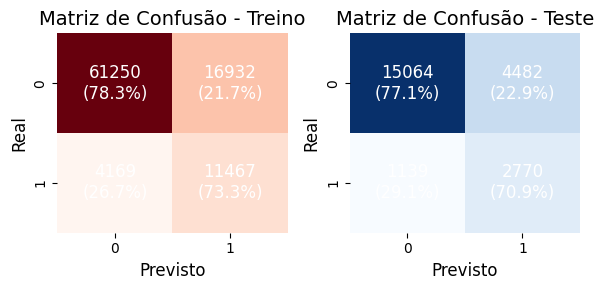

In [32]:
plot_matriz_confusao(y_true_train, y_pred_train, y_true_test, y_pred_test, 
                     size=(6,3), cmap_train="Reds", cmap_test="Blues", 
                     save_path=f'{FIGURES_DIR}/matriz_confusao_XGBoost_final.png')

## Salvar modelo treinado em pickle

In [33]:
# Definir o caminho do modelo e seu nome
caminho_modelo = f"{MODELS_DIR}/modelo_xgboost.pkl"

In [34]:

with open(caminho_modelo, "wb") as file:
    pickle.dump(model, file)

print(f"Modelo salvo em: {caminho_modelo}")

Modelo salvo em: C:\Users\Natalia\OneDrive\Documentos\PROJETOS\Kognita\x_health\models/modelo_xgboost.pkl
